In [645]:
from pyaudi import gdual
from pyaudi import sin, cos, tanh, exp, log
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

Newton's method to train a neural network:

    Inputs: 3
    Hidden layers: 2 with 5 units/layer
    Outputs: 1

We need derivatives up to order 1

In [646]:
n_inputs = 20
order = 2

Create symbolic variables for the weights, initialized to $\mathcal N(0,0.1)$

In [647]:
def initialize_weights(n_inputs, order):

    weights = []
    for unit in range(n_inputs+1):
                symname = 'w_{{{0}}}'.format(unit)
                w = gdual(np.random.randn(), symname , order)
                weights.append(w)
          
    return weights

weights = initialize_weights(n_inputs,order)

In [648]:
def sig(x):
    return 1/(1+exp(-1*x))

Create a function which output is the symbolic expression of the neural network

In [649]:
def logistic_regression_f(inputs, w):
    
    unit_output = w[0]
    for unit in range(len(weights)-1):
        unit_output += inputs[unit]*weights[unit+1]           
    return sig(unit_output)

Define symbolic variables for the inputs and compute the (random) output of the network

In [780]:
x = np.random.rand(n_inputs)

N = logistic_regression_f(x, weights)
print('N(x) = {0}'.format(N.constant_cf))
N

N(x) = 0.9998405360080906


-3.70071e-05*dw_{17}*dw_{7}-1.4961e-05*dw_{10}*dw_{13}-2.11249e-05*dw_{12}*dw_{17}-3.43296e-05*dw_{3}**2-1.48729e-06*dw_{10}*dw_{8}-7.51406e-07*dw_{8}**2-1.25739e-05*dw_{18}*dw_{3}-6.24605e-06*dw_{0}*dw_{16}-4.51803e-05*dw_{12}*dw_{14}-1.66206e-05*dw_{17}*dw_{6}-6.48678e-06*dw_{2}*dw_{6}-2.20247e-05*dw_{0}*dw_{4}-9.64049e-05*dw_{0}*dw_{14}-1.58571e-05*dw_{20}*dw_{9}-2.12317e-05*dw_{1}*dw_{9}+1.89298e-05*dw_{20}-3.72007e-06*dw_{20}*dw_{5}+2.53459e-05*dw_{1}-0.000130414*dw_{11}*dw_{9}+0.000155685*dw_{11}+...

The desired output of the network is: $y(\mathcal x)= x_1x_2 + 0.5x_3 +2$

In [781]:
np.random.seed(0)
proj_ws = np.random.rand(n_inputs,2)

def vis_proj(x):
    x = np.asarray(x)
    x = x.reshape(-1,n_inputs)
    np.random.seed(0)    
    return np.dot(x,proj_ws)
    

In [782]:
def y_f(x):
    x = vis_proj(x)    
    ws = np.asarray([1,0.4]).reshape(2,1)
    y = np.sum(np.dot(x, ws),1)
    y += np.random.randn(y.shape[0])
    y[y>0] = 1
    y[y<0] = 0
    return y

y = y_f(x)
print('y = {0}'.format(y))

y = [ 1.]


In [783]:
X_train = np.random.rand(500, n_inputs)*5-2.5
X_test  = np.random.rand(500, n_inputs)*5-2.5

Y_train = y_f(X_train)
Y_test = y_f(X_test)

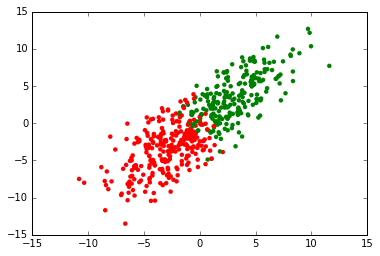

In [784]:
X_vis = vis_proj(X_test)
for i in range(X_test.shape[0]):
    if Y_test[i] == 1:
        plt.scatter(X_vis[i,0], X_vis[i,1], c='green', edgecolors='none')
    else:
        plt.scatter(X_vis[i,0], X_vis[i,1], c='red', edgecolors='none')
        

And the training process will seek to minimize a loss function corresponding to the quadratic error

In [785]:
def loss_f(N,y):
    if N.constant_cf==0 or N.constant_cf==1:        
        if N.constant_cf==y:
            return N*0
        else:
            return N/N          
    return -1*((N)**y+(1-N)**(1-y))

loss = loss_f(N, y)
print('loss = {0}'.format(loss.constant_cf))
loss

loss = -1.9998405360080906


3.70071e-05*dw_{17}*dw_{7}+1.4961e-05*dw_{10}*dw_{13}+2.11249e-05*dw_{12}*dw_{17}+3.43296e-05*dw_{3}**2+1.48729e-06*dw_{10}*dw_{8}+7.51406e-07*dw_{8}**2+1.25739e-05*dw_{18}*dw_{3}+6.24605e-06*dw_{0}*dw_{16}+4.51803e-05*dw_{12}*dw_{14}+1.66206e-05*dw_{17}*dw_{6}+6.48678e-06*dw_{2}*dw_{6}+2.20247e-05*dw_{0}*dw_{4}+9.64049e-05*dw_{0}*dw_{14}+1.58571e-05*dw_{20}*dw_{9}+2.12317e-05*dw_{1}*dw_{9}-1.89298e-05*dw_{20}+3.72007e-06*dw_{20}*dw_{5}-2.53459e-05*dw_{1}+0.000130414*dw_{11}*dw_{9}-0.000155685*dw_{11}+...

In [786]:
def GD_update(loss, w, lr):
    
    for i in range(len(w)):
                wi = w[i]
                if wi.symbol_set[0] in loss.symbol_set:
                    idx = loss.symbol_set.index(wi.symbol_set[0])
                    dw_idx = [0]*loss.symbol_set_size                    
                    dw_idx[idx] = 1
                    w[i] -= loss.get_derivative(dw_idx) * lr
    return w

In [799]:
initial_weights = initialize_weights(n_inputs, order)                

In [800]:
epochs = 100
weights = initial_weights.copy()
gd_loss_history = []

for e in range(epochs):
    
    if 0 == (e%10):
        #Meassures the train accuracy
        acc = 0
        for xi in X_train:
            N = logistic_regression_f(xi, weights)
            pred = N.constant_cf
            if pred > 0.5:
                pred = 1
            else:
                pred = 0
            if pred == y_f(xi):
                acc += 1/X_train.shape[0]            
        
        print('Epoch {0}: accuracy {1}'.format(e, acc))    
        gd_loss_history.append(acc)
        
    loss = 0
    for xi in X_train:
            N = logistic_regression_f(xi, weights)
            loss += loss_f(N, y_f(xi))   
            
    loss /= X_train.shape[0]
    weights = GD_update(loss, weights, 1)    


Epoch 0: accuracy 0.5920000000000004


KeyboardInterrupt: 

0.91


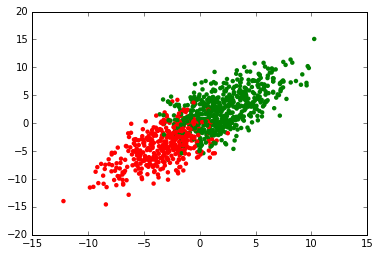

In [771]:
errors = 0

X_vis = vis_proj(X)
for i in range(X.shape[0]):
    N = logistic_regression_f(X[i,:], weights)
    pred = N.constant_cf
    
    if pred > 0.5:
            pred = 1
    else:
            pred = 0
    if pred == 1:
        plt.scatter(X_vis[i,0], X_vis[i,1], c='green', edgecolors='none')
    else:
        plt.scatter(X_vis[i,0], X_vis[i,1], c='red', edgecolors='none')
   
    if pred == y_f(X[i,::]):                
        errors +=1
        
print(errors*1.0/X.shape[0])        

We update the weights with gradient descent using the Hessian and the first order derivatives of the loss function with respect to the weights (and biases)

In [772]:
def hessian(loss, w):
    
    num_params = len(w)
    
    partials = np.zeros((num_params, num_params))

    for i in range(len(w)):
        for ii in range(len(w)):
            wi = w[i]
            wii = w[ii]
            if wi.symbol_set[0] in loss.symbol_set and wii.symbol_set[0] in loss.symbol_set:
                idx = loss.symbol_set.index(wi.symbol_set[0])
                iidx = loss.symbol_set.index(wii.symbol_set[0])
                dw_idx = [0]*loss.symbol_set_size                    
                dw_idx[idx] += 1
                dw_idx[iidx] += 1
                partial = loss.get_derivative(dw_idx)
            else:
                partial = 0

            partials[i,ii] = partial
    return partials#np.linalg.inv(partials)

In [773]:
def first_order_devs(loss, w):
    
    num_params = len(w)
    
    devs = np.zeros((num_params))

    for i in range(len(w)):
            if w[i].symbol_set[0] in loss.symbol_set:
                dw_idx = [0]*loss.symbol_set_size                    
                dw_idx[i] = 1
                d = loss.get_derivative(dw_idx)
            else:
                d = 0

            devs[i] = d
            
    return devs

In [813]:
def Newton_update(loss, w):
    

    d = first_order_devs(loss, w)
    H = hessian(loss, w)
    
    #updates = np.dot(H, d.reshape(-1,1))
    updates = np.linalg.lstsq(H,d)[0]
    
    i=0
    for i in range(len(w)):
        w[i] -= updates[i]
    
    return w

In [1050]:
def loss_f(N,y):
    if N.constant_cf == 0:
        if y==0:
            return 0*N
        else:
            return log(N+1e-10)
    elif N.constant_cf ==1:
        if y==1:
            return 0*N
        else:
            return log(1-N+1e-10)
        
    return -1*(log(N)*y+log(1-N)*(1-y))
    #return -1*((N)**y+(1-N)**(1-y))



In [1078]:
initial_weights = initialize_weights(n_inputs, order)                

In [1079]:
weights = initial_weights.copy()

In [1084]:
for j in range(1):
        loss = 0
        for i in range(X_train.shape[0]):
                    N = logistic_regression_f(X_train[i], weights)
                    loss += loss_f(N, Y_train[i]) 
                    print(loss_f(N, Y_train[i]).constant_cf)
        loss /= X_train.shape[0]
        print(loss.constant_cf)
        d = first_order_devs(loss, weights)
        H = hessian(loss, weights)
        updates = np.linalg.lstsq(H,d)[0]
        print(updates)
        for i in range(len(weights)):
                weights[i] -= updates[i]
            
        #Meassures the train accuracy
        acc = 0
        for i in range(X_train.shape[0]):
            N = logistic_regression_f(X_train[i], weights)
            pred = N.constant_cf
            if pred > 0.5:
                pred = 1
            else:
                pred = 0
            if pred == Y_train[i]:
                acc += 1/X_train.shape[0]            
        
        print('Epoch {0}: accuracy {1}'.format(e, acc))    
        Newton_loss_history.append(acc)
        
            

0.0
-23.025850929940457
0.0
-23.025850929940457
-23.025850929940457
0.0
-23.025850929940457
0.0
0.0
-23.025850929940457
0.0
-23.025850929940457
-23.025850929940457
-23.025850929940457
0.0
0.0
0.0
0.0
0.0
0.0
-23.025850929940457
0.0
-23.025850929940457
-23.025850929940457
-23.025850929940457
-23.025850929940457
0.0
-23.025850929940457
-23.025850929940457
0.0
0.0
0.0
-23.025850929940457
0.0
0.0
-23.025850929940457
-23.025850929940457
0.0
-23.025850929940457
0.0
-23.025850929940457
0.0
0.0
-23.025850929940457
0.0
-23.025850929940457
0.0
0.0
-23.025850929940457
-23.025850929940457
0.0
-23.025850929940457
0.0
0.0
-23.025850929940457
0.0
-23.025850929940457
-23.025850929940457
0.0
-23.025850929940457
0.0
0.0
-23.025850929940457
0.0
-23.025850929940457
0.0
-23.025850929940457
0.0
0.0
-23.025850929940457
-23.025850929940457
0.0
0.0
0.0
-23.025850929940457
0.0
0.0
0.0
-23.025850929940457
0.0
-23.025850929940457
-23.025850929940457
0.0
-23.025850929940457
0.0
-23.025850929940457
-23.025850929940

In [1075]:
for w in weights:
    print(w.constant_cf)

3.404276049932445e+29
433318188453002.5
1.4294076592748648e+16
9310783133593098.0
1.4251677310933876e+16
-1.0902715599239196e+16
-2837861163025661.0
-1.911029523193886e+16
3369515370167113.0
-2010779643321878.2
-2.303757286423569e+16
-1.405466100687358e+16
3909061572331916.0
5509087704253995.0
2906267810676649.0
3.751747205181133e+16
-6.5771214819930744e+16
-4226460477535513.0
-240562485849137.0
-1.1614281858582292e+16
546917671843394.0


In [1076]:
        #Meassures the train accuracy
        acc = 0
        for i in range(X_train.shape[0]):
            N = logistic_regression_f(X_train[i], weights)
            pred = N.constant_cf
            if pred > 0.5:
                pred = 1
            else:
                pred = 0
            if pred == Y_train[i]:
                acc += 1/X_train.shape[0]            
        
        print('Epoch {0}: accuracy {1}'.format(e, acc))    
        Newton_loss_history.append(acc)
        


Epoch 72: accuracy 0.47000000000000036


0.259


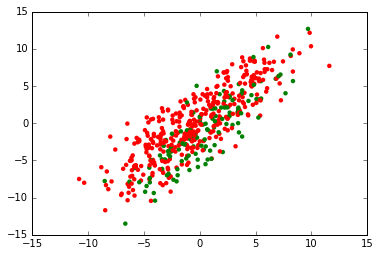

In [1061]:
errors = 0

X_vis = vis_proj(X_test)
for i in range(X_test.shape[0]):
    N = logistic_regression_f(X_test[i,:], weights)
    pred = N.constant_cf
    
    if pred > 0.5:
            pred = 1
    else:
            pred = 0
    if pred == 1:
        plt.scatter(X_vis[i,0], X_vis[i,1], c='green', edgecolors='none')
    else:
        plt.scatter(X_vis[i,0], X_vis[i,1], c='red', edgecolors='none')
   
    if pred == Y_test[i]:                
        errors +=1
        
print(errors*1.0/X.shape[0])        

In [ ]:
weights = initial_weights.copy()

In [855]:
epochs = 100
weights = initial_weights.copy()
Newton_loss_history = []

for e in range(epochs):
    
    if 0 == (e%10):
        #Meassures the train accuracy
        acc = 0
        for i in range(X_train.shape[0]):
            N = logistic_regression_f(X_train[i], weights)
            pred = N.constant_cf
            if pred > 0.5:
                pred = 1
            else:
                pred = 0
            if pred == Y_train[i]:
                acc += 1/X_train.shape[0]            
        
        print('Epoch {0}: accuracy {1}'.format(e, acc))    
        Newton_loss_history.append(acc)
        
    loss = 0
    for i in range(X_train.shape[0]):
            N = logistic_regression_f(X_train[i], weights)
            loss += loss_f(N, Y_train[i])
            
    loss /= X_train.shape[0]
    weights = Newton_update(loss, weights)    


Epoch 0: accuracy 0.5960000000000004
Epoch 10: accuracy 0.46400000000000036
Epoch 20: accuracy 0.46400000000000036
Epoch 30: accuracy 0.46400000000000036
Epoch 40: accuracy 0.46400000000000036
Epoch 50: accuracy 0.46400000000000036
Epoch 60: accuracy 0.46400000000000036
Epoch 70: accuracy 0.46400000000000036


KeyboardInterrupt: 

0.461


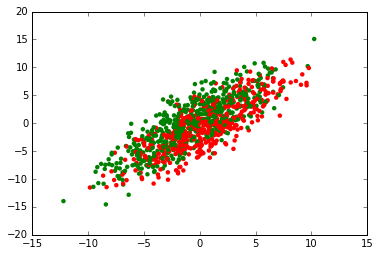

In [831]:
errors = 0

X_vis = vis_proj(X)
for i in range(X.shape[0]):
    N = logistic_regression_f(X[i,:], weights)
    pred = N.constant_cf
    
    if pred > 0.5:
            pred = 1
    else:
            pred = 0
    if pred == 1:
        plt.scatter(X_vis[i,0], X_vis[i,1], c='green', edgecolors='none')
    else:
        plt.scatter(X_vis[i,0], X_vis[i,1], c='red', edgecolors='none')
   
    if pred == y_f(X[i,::]):                
        errors +=1
        
print(errors*1.0/X.shape[0])        

In [ ]:
plt.plot(gd_loss_history)
plt.plot(Newton_loss_history)